#A Fronteira Eficiente: Construindo a Carteira Ideal com Python e Markowitz
_(Baseado em: https://medium.com/@dluiz815/a-fronteira-eficiente-construindo-a-carteira-ideal-com-python-e-markowitz-parte-1-7d6ff360872c)_

In [ ]:
import yfinance as yf
import numpy as np

# --- 1. CONFIGURAÇÃO E DADOS ---
# Escolhendo ativos descorrelacionados (Setores: Indústria, Banco,
#                                       Energia, Varejo, Ouro/Dólar via ETF)

tickers = ['WEGE3.SA', 'ITUB4.SA', 'VALE3.SA', 'LREN3.SA', 'IVVB11.SA']

# Baixando dados dos últimos 5 anos
dados = yf.download(tickers, start="2020-01-01")['Close']

# Cálculo dos Retornos Logarítmicos (Melhor para séries temporais financeiras)
retornos_log = np.log(dados / dados.shift(1))

/tmp/ipython-input-2452735309.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers, start="2020-01-01")['Close']
[*********************100%***********************]  5 of 5 completed


In [ ]:
# Simulação de 10.000 portfólios distintos
num_portfolios = 10000

# Inicializando arrays para armazenar os resultados
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)
all_weights = [] # Initialize list to store all weights

# Definindo a taxa livre de risco (exemplo: 2% ao ano)
risk_free_rate = 0.02

for i in range(num_portfolios):
    # Pesos aleatórios (garantindo que a soma seja 100%)
    weights = np.array(np.random.random(len(tickers)))
    weights /= np.sum(weights)
    all_weights.append(weights) # Store the weights

    # APLICAÇÃO DA TEORIA DE MARKOWITZ:

    # 1. Retorno Esperado (Média ponderada)
    ret_arr[i] = np.sum(retornos_log.mean() * weights) * 252

    # 2. Risco da Carteira (Fórmula Matricial: w.T * Cov * w)
    # Aqui a diversificação acontece matematicamente
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(retornos_log.cov() * 252,
                          weights)))

    # 3. Índice de Sharpe (Eficiência)
    sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]

In [ ]:
max_sharpe_idx = np.argmax(sharpe_arr)
min_vol_idx = np.argmin(vol_arr)

sharpe_portfolio_return = ret_arr[max_sharpe_idx]
sharpe_portfolio_volatility = vol_arr[max_sharpe_idx]

min_vol_portfolio_return = ret_arr[min_vol_idx]
min_vol_portfolio_volatility = vol_arr[min_vol_idx]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for all simulated portfolios
portfolios = pd.DataFrame({
    'Retorno': ret_arr,
    'Volatilidade': vol_arr,
    'Sharpe Ratio': sharpe_arr
})

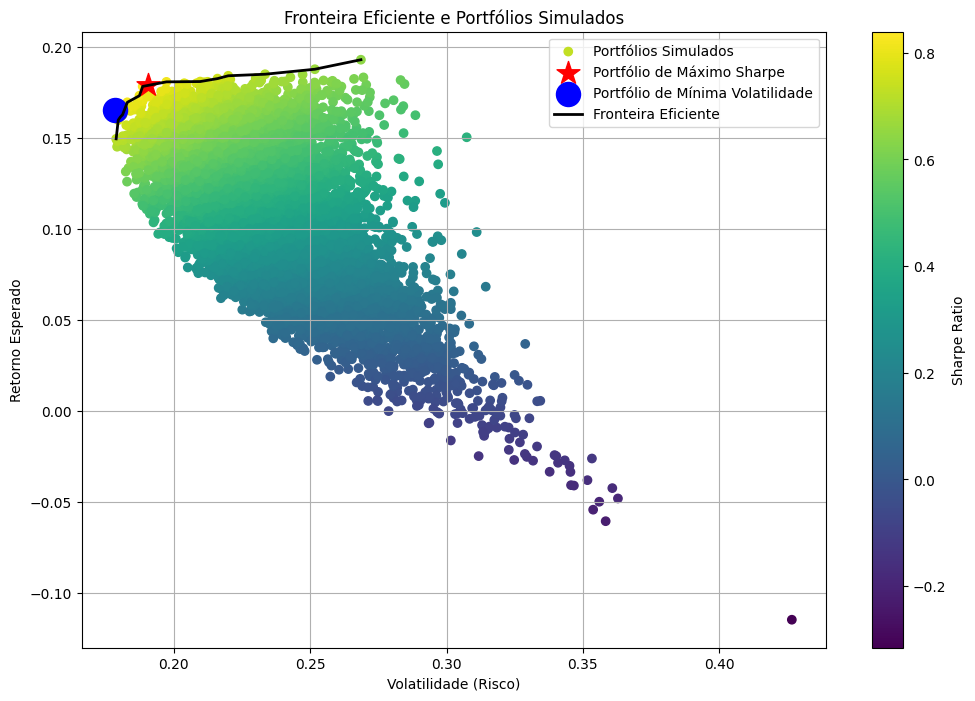

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(portfolios['Volatilidade'], portfolios['Retorno'], c=portfolios['Sharpe Ratio'], cmap='viridis', label='Portfólios Simulados')
plt.colorbar(label='Sharpe Ratio')

# Highlight max Sharpe ratio portfolio
plt.scatter(sharpe_portfolio_volatility, sharpe_portfolio_return, marker='*', color='red', s=300, label='Portfólio de Máximo Sharpe')

# Highlight minimum volatility portfolio
plt.scatter(min_vol_portfolio_volatility, min_vol_portfolio_return, marker='o', color='blue', s=300, label='Portfólio de Mínima Volatilidade')

# Calculate the Efficient Frontier
# Sort portfolios by volatility
portfolios_sorted_by_vol = portfolios.sort_values(by='Volatilidade')

efficient_frontier_points = []
max_return_for_volatility = -np.inf

for i, row in portfolios_sorted_by_vol.iterrows():
    if row['Retorno'] > max_return_for_volatility:
        efficient_frontier_points.append(row)
        max_return_for_volatility = row['Retorno']

efficient_frontier_df = pd.DataFrame(efficient_frontier_points)

# Plot the Efficient Frontier
plt.plot(efficient_frontier_df['Volatilidade'], efficient_frontier_df['Retorno'], color='black', linestyle='-', linewidth=2, label='Fronteira Eficiente')

plt.title('Fronteira Eficiente e Portfólios Simulados')
plt.xlabel('Volatilidade (Risco)')
plt.ylabel('Retorno Esperado')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
max_sharpe_portfolio = portfolios.iloc[max_sharpe_idx]
print("\n--- Portfólio de Máximo Sharpe Ratio ---")
print(f"Retorno Esperado: {max_sharpe_portfolio['Retorno']:.2%}")
print(f"Volatilidade (Risco): {max_sharpe_portfolio['Volatilidade']:.2%}")
print(f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.2f}")


--- Portfólio de Máximo Sharpe Ratio ---
Retorno Esperado: 14.55%
Volatilidade (Risco): 22.66%
Sharpe Ratio: 0.55


In [ ]:
max_sharpe_weights = all_weights[max_sharpe_idx]

print("\n--- Pesos do Portfólio de Máximo Sharpe Ratio ---")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {max_sharpe_weights[i]:.2%}")


--- Pesos do Portfólio de Máximo Sharpe Ratio ---
WEGE3.SA: 24.54%
ITUB4.SA: 13.98%
VALE3.SA: 6.99%
LREN3.SA: 33.81%
IVVB11.SA: 20.68%


In [ ]:
def calculate_shares_to_buy(weights, current_prices, total_investment):
    """
    Calculates the number of shares to buy for each asset.

    Args:
        weights (np.array): Array of portfolio weights for each asset.
        current_prices (pd.Series or np.array): Current price of each asset.
        total_investment (float): Total amount of money to invest.

    Returns:
        pd.Series: Number of shares to buy for each asset (integer values).
    """
    # Calculate the amount to invest in each asset
    investment_per_asset = weights * total_investment

    # Calculate the number of shares for each asset (using floor to avoid fractional shares)
    shares_to_buy = np.floor(investment_per_asset / current_prices)

    return pd.Series(shares_to_buy, index=tickers)

# Exemplo de uso:
# Obter os preços atuais (últimos preços disponíveis no DataFrame 'dados')
current_prices = dados.iloc[-1]

# Definir o valor total a ser investido
total_investment_amount = 10000.0  # Exemplo: R$ 10.000

# Calcular o número de ações a comprar
shares_for_max_sharpe = calculate_shares_to_buy(max_sharpe_weights, current_prices, total_investment_amount)

print(f"\n--- Número de Ações a Comprar para um Investimento de R$ {total_investment_amount:,.2f} ---")
print(shares_for_max_sharpe)


--- Número de Ações a Comprar para um Investimento de R$ 10,000.00 ---
WEGE3.SA     38.0
ITUB4.SA     50.0
VALE3.SA     38.0
LREN3.SA     45.0
IVVB11.SA     3.0
Name: 2026-02-09 00:00:00, dtype: float64
